### Detector de estado sólido

The data file (CV_10kHz.txt) is just a two column file, 1st column V, second column C. 

The function to analyse the data is called CVanalysis is available here:
https://github.com/mbomben/root_macros/blob/master/CV.C

To use it:

gROOT->Reset();

gROOT->LoadMacro("CV.C+”);

CVanalysis("CV_100kHz.txt","DATA",9e-2,1, 5,10, 50,v,ev,neff,eneff,w,ew,true);

where the first argument is the data file; the second is just a flag to signal it is data; third is the area of the diode in cm^2; the next 4 are the ranges for the fit of the 2 straight lines in log log plot - see the attached slide - the first two are for the underdepleted part, the other two for the overdepleted part; the next 6 variables are used to store the result of the fit for: depletion voltage, error on depletion voltage, effective doping concentration, error on eff. dop. conc., thickness, error on thickness; the last parameter is to save plots.

The macro perform the fits using the 4 fit range values provided (https://github.com/mbomben/root_macros/blob/master/CV.C#L261) and then it repeats the fit by varying each value up and down by 10% (https://github.com/mbomben/root_macros/blob/master/CV.C#L261 - 289).
The real fit is done in the CV funtion:
https://github.com/mbomben/root_macros/blob/master/CV.C#L22



In this case we fit the red line - below depletion -  from 1 to 5 volts, the blue one - above depletion - from 10 to 50 volts. 
The macro saves 3 plots, 1 for CV, 1 for C^-2 vs V and one for logC - logV. Examples in attachment. 

For IV apart from plotting I don’t do that much. One could evaluate the current at Vdepl + 50 V.

### Proceso

Caracterización de diodos de silicio. El proceso consiste en estimar el ancho e la zona de deplexión $w$, el voltaje de la zona de deplexión $V_{dep}$ y la concentración de dopaje efectiva $N_{eff}$ desde las mediciones CV del diodo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
CV_data = np.loadtxt('CV_10kHz.txt')
V = CV_data[:,0]
C = CV_data[:,1]

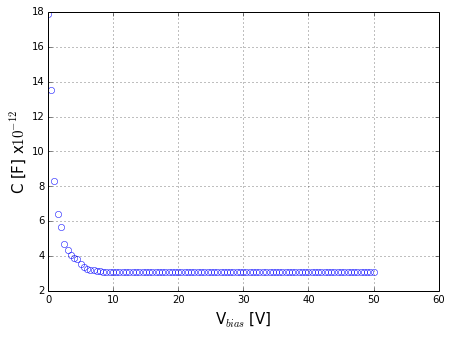

In [3]:
plt.figure(figsize =(7,5))
plt.plot(V,C*1e12, 'ob', fillstyle = 'none')
plt.xlabel("V$_{bias}$ [V]", fontsize=15)
plt.ylabel("C [F] x$10^{-12}$", fontsize=15)
plt.grid()
plt.show()

### Procesamiento

In [17]:
eR = 11.9;     # Silicon relative dielectric constant
e0 = 8.85e-14; # F/cm
q0 = 1.6e-19;  # C

# input parameters
A = 9e-2

In [98]:
c = np.abs(C)
v = np.abs(V)
logC = np.log10(c)
logV = np.log10(v)
C2 = 1/c/c

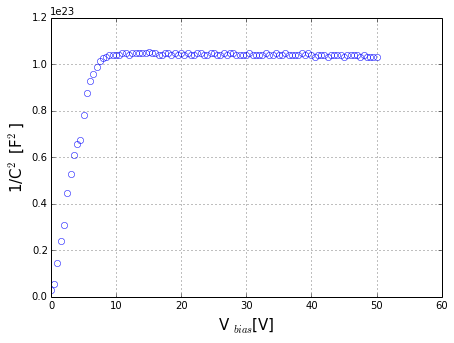

In [153]:
plt.figure(figsize =(7,5))
plt.plot(V,C2, 'ob', fillstyle = 'none')
plt.xlabel("V $_{bias}$[V]", fontsize=15)
plt.ylabel("1/C$^2$ [F$^2$]", fontsize=15)
plt.grid()
plt.show()

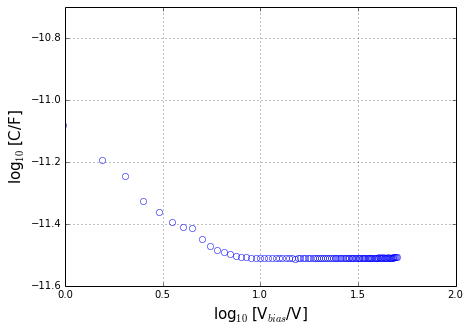

In [7]:
plt.figure(figsize =(7,5))
plt.plot(logV,logC, 'ob', fillstyle = 'none')
plt.xlabel("log$_{10}$ [V$_{bias}$/V]", fontsize=15)
plt.ylabel("log$_{10}$ [C/F]", fontsize=15)
plt.xlim([0,2])
plt.grid()
plt.show()

### Ajuste

In [8]:
# Funcion de ajuste
def loglin(x, a, b):
    return a + b*x

$$\chi^2 = \sum_i \frac{(X-X_{exp})^2}{\sigma^2}$$

In [139]:
logv1 = 2
logv2 = 13
logv3 = 16
logv4 = 100
N = 101   # fit points

initial_guess = [0, 0]
pars1, pcov1 = curve_fit(loglin, logV[logv1:logv2], logC[logv1:logv2], p0=initial_guess)
pars2, pcov2 = curve_fit(loglin, logV[logv3:logv4], logC[logv3:logv4], p0=initial_guess)

xloglin1 = np.linspace(logV[logv1],logV[logv2],N)
yloglin1 = loglin(logV[logv1:logv2], pars1[0], pars1[1])

xloglin2 = np.linspace(0.8,2,N)
yloglin2 = loglin(logV[logv3:logv4], pars2[0], pars2[1])

# Fit parameters

logq1 = pars1[0]
logq2 = pars2[0]
logm1 = pars1[1]
logm2 = pars2[1]

# Fit errors
perr1 = np.sqrt(np.diag(pcov1))
perr2= np.sqrt(np.diag(pcov2))

elogq1 = perr1[0]
elogq2 = perr2[0]
elogm1 = perr1[1]
elogm2 = perr2[1]

chi1 = np.sum(((yloglin1-logC[logv1:logv2])/np.std(logV[logv1:logv2]))**2)
chi2 = np.sum(((yloglin2-logC[logv3:logv4])/np.std(logV[logv3:logv4]))**2)


Voltage de deplexión

$$\alpha = {\frac{log_{q1}-log_{q2}}{log_{m2}-log_{m1}}}$$
$$V_{depl} = 10^{\alpha}$$

Errores

$$\Delta_m = \sqrt{elog_{m1}^2 + elog_{m2}^2}$$
$$\Delta_q = \sqrt{elog_{q1}^2 + elog_{q2}^2}$$

$$\beta = \sqrt{\frac{\Delta_q^2}{(log_{m2}-log_{m1})^2} + \frac{\Delta_m^2 (log_{q1}-log_{q2})^2}{(log_{m2}-log_{m1})^2}}$$

$$eV_{depl} = 10^{\beta}$$

In [134]:
logvdep = (logq1-logq2)/(logm2-logm1)
vdepl = pow(10., logvdep)  # depletion voltage

Deltam = np.sqrt(elogm1**2 + elogm2**2)
Deltaq = np.sqrt(elogq1**2 + elogq2**2)

evdepl = np.sqrt(pow(Deltaq,2.)/pow((logm2-logm1),2.) + pow(Deltam,2.)*pow((logq1-logq2),2.)/pow((logm2-logm1),2.))
evdepl = pow(10., evdepl)

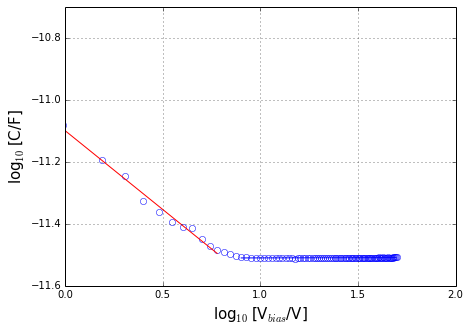

In [135]:
plt.figure(figsize =(7,5))
plt.plot(logV,logC, 'ob', fillstyle = 'none')
plt.plot(logV[logv1:logv2],yloglin1, 'r')
plt.plot(logV[logv3:logv4],yloglin2, 'b')
plt.xlabel("log$_{10}$ [V$_{bias}$/V]", fontsize=15)
plt.ylabel("log$_{10}$ [C/F]", fontsize=15)
plt.xlim([0,2])
plt.grid()
plt.show()

In [148]:
initial_guess = [0, 0]
pars3, pcov3 = curve_fit(loglin, V[logv1:logv2], C2[logv1:logv2]/1e23, p0=initial_guess)

xloglin3 = np.linspace(V[logv1],V[logv2],N)
yloglin3 = loglin(V[logv1:logv2], pars3[0], pars3[1])*1e23

# Fit parameters

Vder = pars3[0]*1e23
C2der = pars3[1]*1e23

# Fit errors
perr3 = np.sqrt(np.diag(pcov3))

eVder = perr3[0]*1e23
eC2der = perr3[1]*1e23

chi3 = np.sum(((yloglin3-C2[logv1:logv2])/np.std(V[logv1:logv2]))**2)

El ancho de a zona de deplexión se define como

$$w = \sqrt{\frac{2\varepsilon V}{e N_{eff}}}$$

donde $\varepsilon$ es la permitividad del material, $e$ es la carga del electrón, $V$ el voltaje y $N_{eff}$ el dopaje efectivo del material.

In [149]:
neff = 2./A/A/q0/eR/e0/C2der
eneff = 2./A/A/q0/eR/e0/C2der/C2der*eC2der

w = pow(2.*eR*e0*vdepl/q0/neff,0.5)

ewA = 2*eR*e0/q0
ewA = pow(ewA,0.5)

ewNeff = 0.5*ewA*pow(vdepl,0.5)*pow(neff,-1.5)*eneff
ewV = 0.5*ewA*pow(vdepl,-0.5)*pow(neff,-0.5)*evdepl

ew = np.sqrt(ewNeff*ewNeff+ewV*ewV)

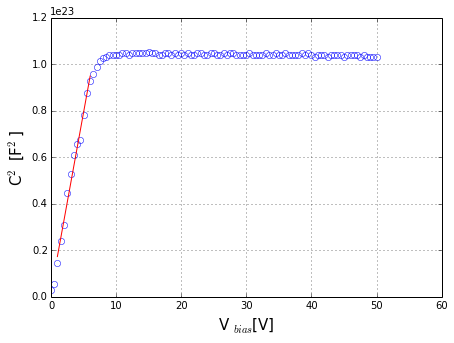

In [151]:
plt.figure(figsize =(7,5))
plt.plot(V,C2, 'ob', fillstyle = 'none')
plt.plot(V[logv1:logv2],yloglin3, 'r')
plt.xlabel("V $_{bias}$[V]", fontsize=15)
plt.ylabel("C$^2$ [F$^2$]", fontsize=15)
plt.grid()
plt.show()

In [152]:
print ("*********************************")
print ("Chi2      = %f" % chi1)
print ("p0        = %f +/- %f" % (logq1, elogq1))
print ("p1        = %f +/- %f\n" % (logm1, elogm1))

print ("*********************************")
print ("Chi2      = %e" % chi2)
print ("p0        = %f +/- %f" % (logq2, elogq2))
print ("p1        = %f +/- %f\n" % (logm2, elogm2))

print ("*********************************")
print ("Chi2      = %e" % chi3)
print ("p0        = %e +/- %e" % (Vder, eVder))
print ("p1        = %e +/- %e\n" % (C2der, eC2der))

print ("v1 = %f V") % V[logv1]
print ("v2 = %f V") % V[logv2]
print ("v3 = %f V") % V[logv3]
print ("v4 = %f V") % V[logv4]

print ("vdepl = %f V") % vdepl
print ("evdepl = %f V") % evdepl

print ("neff = %e 1./cm^3" % neff)
print ("eneff = %e 1./cm^3" % eneff)
print ("w = %f um" % (w*1e+4))
print ("ew = %f um" % (ew*1e+4))

*********************************
Chi2      = 0.034162
p0        = -11.098822 +/- 0.010095
p1        = -0.508579 +/- 0.018576

*********************************
Chi2      = 1.532582e-03
p0        = -11.510591 +/- 0.000673
p1        = 0.001158 +/- 0.000472

*********************************
Chi2      = 3.741075e+43
p0        = 2.335529e+21 +/- 2.364596e+21
p1        = 1.541763e+22 +/- 6.147246e+20

v1 = 0.975400 V
v2 = 6.498200 V
v3 = 7.978600 V
v4 = 50.001400 V
vdepl = 6.424016 V
evdepl = 1.058975 V
neff = 9.504235e+10 1./cm^3
eneff = 3.789485e+09 1./cm^3
w = 298.294220 um
ew = 25.295285 um
